In [23]:
import os
import pandas as pd
import yaml

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()


In [24]:
root_dir = r".\results\2024Mar21-002326_configs"  

In [25]:
def collect_experiment_data(root_dir):
    """
    Collects experiment data and selected parameters from configuration files across multiple runs.
    
    Parameters:
    - root_dir: The root directory where experiment results are stored.
    
    Returns:
    - A pandas DataFrame containing the collected data and parameters.
    """
    all_data = []

    # Walk through the directory structure
    for subdir, dirs, files in os.walk(root_dir):
        for file in files:
            if file.endswith("loss_record.csv"):
                # Path to the current file
                file_path = os.path.join(subdir, file)
                # Read the loss record CSV file
                df = pd.read_csv(file_path)
                
                # Load the corresponding cfg.yaml file to get parameters
                cfg_path = os.path.join(subdir, "cfg.yaml")
                with open(cfg_path, 'r') as cfg_file:
                    cfg_data = yaml.safe_load(cfg_file)
                
                # Extract needed parameters
                run_id = cfg_data.get('run_id')
                tau = cfg_data['tau']
                lower_bound_softmax = cfg_data['lower_bound_softmax']
                
                # Add parameters as new columns to the DataFrame
                df['run_id'] = run_id
                df['tau'] = tau
                df['lower_bound_softmax'] = lower_bound_softmax
                
                # Append to the list of all data
                all_data.append(df)

    # Concatenate all data into a single DataFrame
    return pd.concat(all_data, ignore_index=True)

combined_data = collect_experiment_data(root_dir)
combined_data

aggregated_df = combined_data.groupby(['run_id', 'tau', 'lower_bound_softmax']).agg({'epoch': 'max'}).reset_index()

aggregated_df

,run_id,tau,lower_bound_softmax,epoch
0,0,0.001,0.5,299
1,0,0.010,0.5,299
2,0,0.100,0.5,299
3,0,1.000,0.5,299
4,1,0.001,0.5,299
5,1,0.010,0.5,299
6,1,0.100,0.5,299
7,1,1.000,0.5,299
8,2,0.001,0.5,299
9,2,0.010,0.5,299


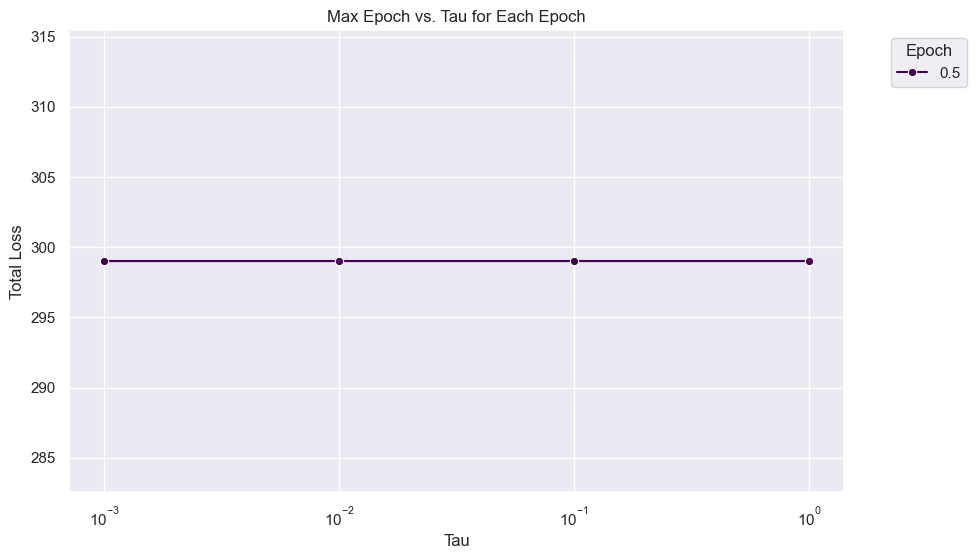

In [26]:
plt.figure(figsize=(10, 6))
# Assuming you want to plot the loss for the last epoch of each run, you can filter or aggregate the data as needed
sns.lineplot(data=aggregated_df, x='tau', y='epoch', hue='lower_bound_softmax', palette='viridis', marker='o')
plt.xlabel('Tau')
plt.ylabel('Total Loss')
plt.xscale('log')
# plt.yscale('log')
plt.title('Max Epoch vs. Tau for Each Epoch')
plt.legend(title='Epoch', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [27]:
def collect_bellman_errors(root_dir):
    """
    Collects Bellman error values and selected parameters from configuration files across multiple runs.
    
    Parameters:
    - root_dir: The root directory where experiment results are stored.
    
    Returns:
    - A pandas DataFrame containing the collected Bellman errors and parameters.
    """
    all_errors = []

    # Walk through the directory structure
    for subdir, dirs, files in os.walk(root_dir):
        for file in files:
            if file == "bellman_error.txt":
                # Path to the current file
                file_path = os.path.join(subdir, file)
                # Read the Bellman error value from the file
                with open(file_path, 'r') as error_file:
                    bellman_error = float(error_file.read().strip())
                
                # Load the corresponding cfg.yaml file to get parameters
                cfg_path = os.path.join(subdir, "cfg.yaml")
                with open(cfg_path, 'r') as cfg_file:
                    cfg_data = yaml.safe_load(cfg_file)
                
                # Extract needed parameters
                run_id = cfg_data.get('run_id')
                tau = cfg_data['tau']
                lower_bound_softmax = cfg_data['lower_bound_softmax']
                
                # Create a dictionary with the collected data
                error_data = {
                    'run_id': run_id,
                    'tau': tau,
                    'lower_bound_softmax': lower_bound_softmax,
                    'bellman_error': bellman_error
                }
                
                # Append to the list of all errors
                all_errors.append(error_data)

    # Convert the list of dictionaries to a DataFrame
    return pd.DataFrame(all_errors)

# Example usage
bellman_errors_df = collect_bellman_errors(root_dir)
bellman_errors_df

,run_id,tau,lower_bound_softmax,bellman_error
0,0,0.001,0.5,1.005421e-02
1,1,0.001,0.5,9.500746e-03
2,2,0.001,0.5,2.065077e-02
3,3,0.001,0.5,1.820529e-02
4,4,0.001,0.5,3.188105e+09
5,5,0.001,0.5,1.561425e-02
6,6,0.001,0.5,1.654608e-02
7,7,0.001,0.5,2.229645e-02
8,8,0.001,0.5,2.228821e-02
9,9,0.001,0.5,6.540790e+00


In [28]:
# bellman_errors_df_filtered = bellman_errors_df[bellman_errors_df["tau"]!=0.01]
bellman_errors_df_filtered = bellman_errors_df[bellman_errors_df["lower_bound_softmax"]!=0]

In [29]:
bellman_errors_df_filtered["tau"].min()

0.001

In [30]:
bellman_errors_df_filtered["lower_bound_softmax"] = bellman_errors_df_filtered["lower_bound_softmax"].astype(str) 

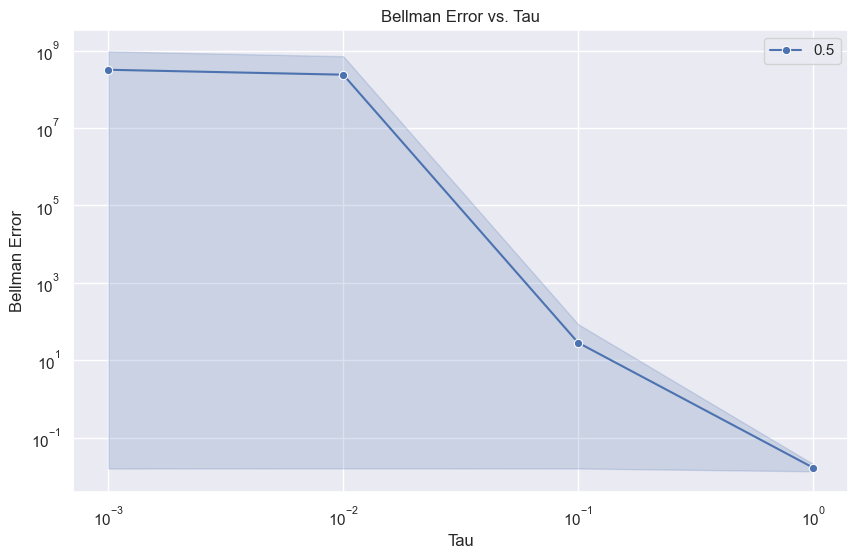

In [31]:
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=bellman_errors_df_filtered,
    x="tau",
    y="bellman_error",
    hue="lower_bound_softmax",
    marker="o",
    # label="Bellman Error",
)
plt.xlabel("Tau")
plt.ylabel("Bellman Error")
plt.xscale("log")
plt.yscale("log")
plt.title("Bellman Error vs. Tau")
plt.legend()
plt.show()

In [37]:
high_tau_df = bellman_errors_df_filtered[bellman_errors_df_filtered["tau"]==1]
high_tau_df['bellman_error'].mean()

0.016808068342506886

In [36]:
bellman_errors_df_filtered["bellman_error"].min()

0.007410506531596184

In [32]:
#use mdp to generate transition distribution
# this generates another dataset of transitions

# then apply:
# ### Training
# input_size = len(states[0])  # Or another way to represent the size of your input
# output_size = len(actions)

# # Initialize the DQN
# dqn = DQN(input_size, output_size)

# loss_record = train_dqn(
#     dqn,
#     sampled_transitions_train,
#     Q_pi_random,
#     states,
#     actions,
#     gamma,
#     epsilon,
#     batch_size=batch_size,
#     max_iterations=train_max_iterations,
#     logger=logger,
# )

# bm_error = compute_bellmans_error(
#     dqn, validation_transitions=transitions_val, gamma=gamma
# )

### AND

# policy evaluation

# plot both

In [33]:
# do policy evaluation on train datasets -> Q 
# Evaluate with Q on validation set

# training DQN == value iteration
# we want to do policy evaluation with DQN (we do this by changing the loss function with bellman equation for Q pi instead of Q*)
# if we want to do early stopping, do it with Q* instead of Q pi random